# GO Analysis for WGCNA
## Phase 2 vs. Phase 2

Gene ontology of modules from WGCNA. Following [Gurr code](https://github.com/SamGurr/Pgenerosa_OA_TagSeq/blob/main/TagSeq/Analysis/Scripts/GO_Analysis_WGCNA_all.R)

## 0. load libraries

In [52]:
library(tidyverse)
library(goseq)
library(reshape2)
library(Rmisc)
library(ggpubr)
library(gridExtra)
library(forcats)
library(zoo)
library(ComplexHeatmap)
library(GO.db)
library(GSEABase)
library(clusterProfiler)

## 1. load data
WGCNA module membership, module colors, and goslim_generic.obo

#### A. gene annotation to GO.term - long format

In [3]:
annot <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
colnames(annot)[1] <- 'Gene'
colnames(annot)[2] <- 'GO.terms'

# One row for each gene and GO.term
annot <- annot %>%
  separate_rows(GO.terms, sep = "; ") %>%
  filter(!is.na(GO.terms) & GO.terms != "")

head(annot)

Gene,GO.terms
<chr>,<chr>
LOC111126949,GO:0005042
LOC111126949,GO:0005737
LOC111126949,GO:0008233
LOC111126949,GO:0016020
LOC111126949,GO:0043123
LOC111126949,GO:0046330


#### B. GOslim data

In [4]:
slim <- getOBOCollection("http://current.geneontology.org/ontology/subsets/goslim_generic.obo")
class(slim)

[1] "OBOCollection"
attr(,"package")
[1] "GSEABase"

In [50]:
# 1. Get the GO IDs
slim_ids <- ids(slim)

# 1. Identify the subset you want to use
target_subset <- "goslim_generic" 

# 2. Get the IDs that belong to THIS specific subset
# We use the subset name to filter the larger collection
slim_ids <- ids(slim[target_subset])

# 3. Now get the Terms for those specific IDs
# We use the GO.db package because it's much faster and more reliable for names
library(GO.db)
slim_terms <- Term(slim_ids)

# 4. Create your lookup table
slim_lookup <- data.frame(
  SlimID = names(slim_terms),
  GOSlim_Bin = as.character(slim_terms),
  stringsAsFactors = FALSE
)

head(slim_lookup)

,SlimID,GOSlim_Bin
,<chr>,<chr>
1,GO:0000228,nuclear chromosome
2,GO:0000278,mitotic cell cycle
3,GO:0000910,cytokinesis
4,GO:0001618,virus receptor activity
5,GO:0002181,cytoplasmic translation
6,GO:0002376,immune system process


In [70]:
# 1. Get a list of all ancestors for every GO term in your WGCNA results
# This creates a mapping of Specific_ID -> All_Ancestors
all_ancestors <- as.list(GOBPANCESTOR)

# 2. Create a function to find the SlimID match
find_slim_parent <- function(specific_id, slim_ids) {
  # Get ancestors for this specific ID
  ancestors <- all_ancestors[[specific_id]]
  # Check which of these ancestors are in your 141 SlimIDs
  match <- intersect(ancestors, slim_ids)
  # Return the first match (or the ID itself if it's already a Slim term)
  if (specific_id %in% slim_ids) return(specific_id)
  return(match[1]) 
}

#### C. Gene info

In [5]:
geneInfo <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_GeneInfo.csv') 
head(geneInfo) 

,Gene,GO.terms,ModuleColor,Combo_treatments.GS.both_both,Combo_treatments.GS.both_warm,Combo_treatments.GS.both_control,Combo_treatments.GS.both_hypoxic,Combo_treatments.GS.control_control,Combo_treatments.GS.control_hypoxic,Combo_treatments.GS.control_both,⋯,MMcyan,MMbrown,MMyellow,MMturquoise,MMpink,MMblack,MMtan,MMsalmon,MMgreenyellow,MMmagenta
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,COX1,GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0045277; GO:0046872,brown,0.01890862,-0.0565456949,-0.07639120,-0.15771421,-0.07403373,-0.01311223,0.088481991,⋯,0.17223558,0.52972753,0.2700327,0.27599905,-0.02328820,-0.04901975,0.03370438,-0.03980008,0.13300933,0.09993804
2,COX2,GO:0004129; GO:0005507; GO:0005743; GO:0070469,brown,-0.02712349,-0.0763355202,-0.04636546,-0.07633242,0.01938493,-0.11795616,0.177115626,⋯,0.20624426,0.60966090,0.1083271,0.24229607,-0.05538884,-0.03260110,-0.06000427,0.04928647,-0.06837658,-0.01441653
3,COX3,GO:0004129; GO:0005743; GO:0008535; GO:0019646; GO:0045277,brown,0.01199400,-0.0923327745,-0.02501484,-0.05114432,0.02632895,-0.07263109,0.105828221,⋯,0.43047835,0.63169637,0.2772417,0.20909597,-0.08887830,-0.04963871,-0.01473983,-0.18648499,-0.23508693,-0.29661590
4,CYTB,GO:0005743; GO:0008121; GO:0022904; GO:0045275; GO:0046872,brown,0.06678880,-0.0001181687,-0.05187666,-0.32304961,0.08920278,-0.20809823,0.006858974,⋯,0.09911882,0.54351840,0.2707225,0.27827386,-0.01382435,0.04921847,0.10926803,-0.08622249,0.05725341,-0.01082276
5,LOC111099029,GO:0005886; GO:0015280; GO:0035725; GO:0046872; GO:0047631; GO:0070588; GO:0099604,blue,0.02251138,0.0324885000,0.06112436,-0.04309088,0.03163502,-0.05860583,-0.036712566,⋯,-0.10486420,-0.17749325,-0.1687577,-0.10730071,-0.17455884,-0.12058475,0.03029584,0.08641709,-0.00399179,0.13704505
6,LOC111099033,GO:0005737; GO:0005886; GO:0005903; GO:0006814; GO:0007420; GO:0008520; GO:0009636; GO:0009925; GO:0015081; GO:0015229; GO:0015882; GO:0016324; GO:0030324; GO:0033300; GO:0043229; GO:0070837,salmon,0.03262849,-0.0054834451,-0.14770857,0.24694553,-0.03531460,-0.10445214,0.128748715,⋯,-0.20497309,-0.02989429,-0.4049090,-0.01626329,0.14476401,0.43674437,0.07854242,0.60551361,0.08920579,0.45935926


categorize gene info columns

In [7]:
# Get all column names once
all_cols <- names(geneInfo)

# 1. The 16 'Combo_treatments.GS' columns
combo_cols <- grep("^Combo_treatments\\.GS\\.", all_cols, value = TRUE)

# 2. Phase 1 & 2 Driver columns (Temp and DO)
p1_driver_cols <- grep("^phase1_(temp|DO)\\.GS\\.", all_cols, value = TRUE)
p2_driver_cols <- grep("^phase2_(temp|DO)\\.GS\\.", all_cols, value = TRUE)

# 3. Overall Phase Treatment columns
p1_overall_cols <- grep("^phase1_treatment\\.GS\\.", all_cols, value = TRUE)
p2_overall_cols <- grep("^phase2_treatment\\.GS\\.", all_cols, value = TRUE)

# 4. Module Membership (MM) colors
mm_cols <- grep("^MM", all_cols, value = TRUE)

#### Module membership

In [8]:
moduleMembership <-  geneInfo %>% dplyr::select(Gene, GO.terms, ModuleColor) # select for genes, GO.ids, modules
head(moduleMembership)

,Gene,GO.terms,ModuleColor
,<chr>,<chr>,<chr>
1,COX1,GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0045277; GO:0046872,brown
2,COX2,GO:0004129; GO:0005507; GO:0005743; GO:0070469,brown
3,COX3,GO:0004129; GO:0005743; GO:0008535; GO:0019646; GO:0045277,brown
4,CYTB,GO:0005743; GO:0008121; GO:0022904; GO:0045275; GO:0046872,brown
5,LOC111099029,GO:0005886; GO:0015280; GO:0035725; GO:0046872; GO:0047631; GO:0070588; GO:0099604,blue
6,LOC111099033,GO:0005737; GO:0005886; GO:0005903; GO:0006814; GO:0007420; GO:0008520; GO:0009636; GO:0009925; GO:0015081; GO:0015229; GO:0015882; GO:0016324; GO:0030324; GO:0033300; GO:0043229; GO:0070837,salmon


In [9]:
# 1. Pivot  GS columns to long format
# This converts 16+ columns into two: 'Treatment' and 'GS_Score'
gene_info_long <- geneInfo %>%
  pivot_longer(
    cols = starts_with("Combo_treatments.GS."), 
    names_to = "Treatment_History", 
    values_to = "GS_Score"
  ) %>%
  # Clean up the prefix to get names like 'both_both', 'warm_warm', etc.
  mutate(Treatment_History = str_remove(Treatment_History, "Combo_treatments.GS."))

pull out modules of interest

In [10]:
# Create a 'Key' for your significant findings
sig_module_key <- tribble(
  ~Phase, ~Factor, ~Significant_Modules,
  "Phase1", "Temp",  c("green", "midnightblue"),
  "Phase1", "Full", c("green", "midnightblue"),
  "Phase2", "Temp",  c("cyan", "yellow", "salmon", "turquoise", "magenta"),
    "Phase2", "DO", c("yellow", "salmon", "magenta"),
    "Phase2", "Full", c('cyan', 'yellow', 'brown', 'turquoise', 'blue', 'salmon', 'magenta', 'red', 'greenyellow', 'pink', 'black')
)
sig_module_key

Phase,Factor,Significant_Modules
<chr>,<chr>,<list>
Phase1,Temp,"green, m...."
Phase1,Full,"green, m...."
Phase2,Temp,"cyan, ye...."
Phase2,DO,"yellow, ...."
Phase2,Full,"cyan, ye...."


here, phase denotes phase 1 or 2, factor denotes if the focus is on temperature, DO, or both DO and temperature together, and then significant modules associated with the phase and 'factor'

In [11]:
WGCNA_ColorList <- c('green', 'midnightblue', 'cyan', 'yellow', 'salmon', 'turquoise', 'magenta', 'brown', 'red', 'greenyellow', 'pink', 'black')
WGCNA_ColorList

[1] "green"        "midnightblue" "cyan"         "yellow"       "salmon"      
 [6] "turquoise"    "magenta"      "brown"        "red"          "greenyellow" 
[11] "pink"         "black"

#### D. vst expression

In [12]:
# counts matrix
dataExpr <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_vstCounts.csv')

# set gene name as rowname
rownames(dataExpr) <- dataExpr$X

 
dataExpr <- dataExpr %>% 
dplyr::select(-X) %>% # remove gene name as column
t() # transpose so samples = rows, genes = columns

head(dataExpr)
dim(dataExpr) # 94 samples x 35466 genes

,LOC111116054,LOC111126949,LOC111110729,LOC111112434,LOC111120752,LOC111128944,LOC111128953,LOC111105691,LOC111133554,LOC111125466,⋯,CYTB,COX2,ATP6,ND2,ND4,ND5,ND6,ND3,ND1,ND4L
B1_B1_O01,7.692872,10.197580,8.354765,7.886383,9.363550,7.548551,7.548551,7.692872,7.548551,7.650623,⋯,18.94773,17.35567,16.72734,16.55278,17.40296,17.50511,15.27334,14.40950,17.08613,13.21049
B1_W5_O50,7.805746,9.653169,8.542687,7.697174,9.355360,7.548551,7.548551,7.845404,7.548551,7.548551,⋯,19.25087,17.60046,17.05547,16.54477,16.97662,17.30129,15.59674,14.95796,17.21506,13.41728
B2_B5_O51,7.871959,9.900281,8.351593,7.548551,9.509373,7.548551,7.548551,8.595408,7.548551,7.651014,⋯,19.41971,17.94342,17.27196,17.23549,17.79404,18.11808,15.98559,15.64247,17.74181,13.77409
B2_C4_O40,7.843091,9.718856,8.513945,7.687586,9.284512,7.548551,7.548551,8.101515,7.843091,7.548551,⋯,18.86611,17.79882,17.27281,16.61824,17.19524,17.19285,15.14694,14.83363,17.01083,13.11047
B3_B4_O41,7.548551,9.612738,8.518601,7.940109,9.198871,7.548551,7.548551,8.014009,7.548551,7.661902,⋯,19.71514,18.17021,17.54836,17.11674,17.49138,17.97654,15.71235,15.28878,17.71717,13.87237
B3_C3_O30,7.909124,9.545333,8.653091,7.989592,9.337765,7.548551,7.710140,8.149132,7.828140,7.926626,⋯,19.27273,17.87689,17.64807,17.08072,17.29751,17.13546,15.58747,15.14063,17.14174,13.28853


[1]    94 35466

#### create term2GO

In [13]:
# col1 = gene ID
# col2 = GO ID 
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


re-format for correct input for `GSEA()` - two columns, one for GO term and one for gene ID

In [15]:
term2gene <- gene2go %>%
  mutate(GO_terms = strsplit(Gene.Ontology.IDs, ",\\s*|;\\s*|`")) %>%  # Split by comma, semicolon, or backtick
  unnest(GO_terms) %>%
  filter(grepl("^GO:", GO_terms)) %>%  # Keep only valid GO terms
  dplyr::select(term = GO_terms, gene = gene)

class(term2gene)
str(term2gene)
head(term2gene)

[1] "tbl_df"     "tbl"        "data.frame"

tibble [223,103 × 2] (S3: tbl_df/tbl/data.frame)
 $ term: chr [1:223103] "GO:0005042" "GO:0005737" "GO:0008233" "GO:0016020" ...
 $ gene: chr [1:223103] "LOC111126949" "LOC111126949" "LOC111126949" "LOC111126949" ...


term,gene
<chr>,<chr>
GO:0005042,LOC111126949
GO:0005737,LOC111126949
GO:0008233,LOC111126949
GO:0016020,LOC111126949
GO:0043123,LOC111126949
GO:0046330,LOC111126949


get term names for GO IDs

In [16]:
# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name)    

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0005737,GO:0005737,cytoplasm
GO:0008233,GO:0008233,peptidase activity
GO:0016020,GO:0016020,membrane
GO:0043123,GO:0043123,positive regulation of canonical NF-kappaB signal transduction
GO:0046330,GO:0046330,positive regulation of JNK cascade


## 2. run GO enrichment

In [24]:
# universal list = input gene list before module assignment, but after gene filtering
universal_genes <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_UniversalGeneList.csv')
head(universal_genes)

,gene
,<chr>
1,LOC111126949
2,LOC111120752
3,LOC111105691
4,LOC111113860
5,LOC111109550
6,LOC111109753


### midnight blue module
significantly correlated with phase 1 temperature

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the enrichplot package.
  Please report the issue at
  <https://github.com/GuangchuangYu/enrichplot/issues>.”


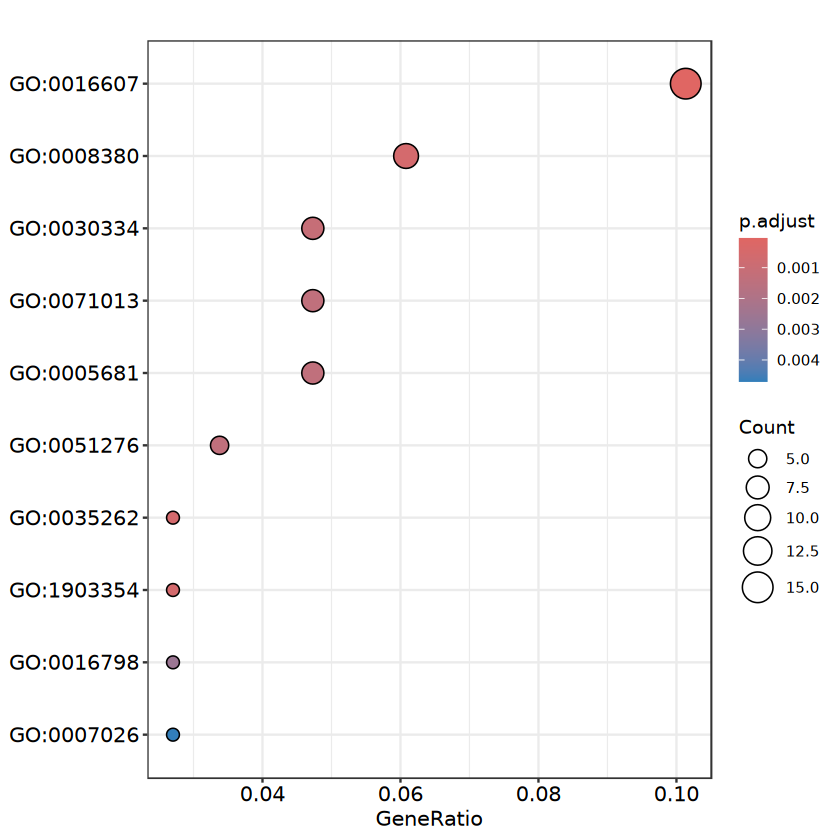

In [32]:
# midnight blue = phase1_temp
target_genes <- geneInfo %>%
  filter(ModuleColor == "midnightblue") %>%
  pull(Gene)

# Run the custom enrichment
ego_custom <- enricher(gene = target_genes,
                       universe = universal_genes$gene,
                       TERM2GENE = term2gene,
                       pvalueCutoff = 0.05)

# View results
dotplot(ego_custom)

In [96]:
midnightblue_res <- as.data.frame(ego_custom)
head(midnightblue_res)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016607,GO:0016607,GO:0016607,15/148,236/13421,5.033606e-08,3.951381e-05,3.258598e-05,LOC111100835/LOC111103655/LOC111103804/LOC111108785/LOC111123630/LOC111125036/LOC111126129/LOC111126732/LOC111127026/LOC111127735/LOC111129112/LOC111130363/LOC111132362/LOC111133985/LOC111137165,15
GO:0008380,GO:0008380,GO:0008380,9/148,103/13421,1.965038e-06,5.558152e-04,4.583659e-04,LOC111100835/LOC111120641/LOC111126129/LOC111126732/LOC111129112/LOC111129152/LOC111130108/LOC111130363/LOC111137165,9
GO:0035262,GO:0035262,GO:0035262,4/148,10/13421,2.832179e-06,5.558152e-04,4.583659e-04,LOC111123643/LOC111124270/LOC111125152/LOC111125159,4
GO:1903354,GO:1903354,GO:1903354,4/148,10/13421,2.832179e-06,5.558152e-04,4.583659e-04,LOC111123643/LOC111124270/LOC111125152/LOC111125159,4
GO:0030334,GO:0030334,GO:0030334,7/148,65/13421,7.015019e-06,1.101358e-03,9.082603e-04,LOC111111223/LOC111115638/LOC111123643/LOC111124270/LOC111125152/LOC111125159/LOC111132609,7
GO:0071013,GO:0071013,GO:0071013,7/148,70/13421,1.153672e-05,1.365777e-03,1.126320e-03,LOC111100835/LOC111102673/LOC111125036/LOC111127735/LOC111132362/LOC111134422/LOC111137383,7


In [97]:
# 1. Convert the SlimID results from a 'list' to a 'character' vector
# This fixes the "incompatible types" error
midnightblue_res$SlimID <- sapply(midnightblue_res$SlimID, function(x) {
  if (is.null(x) || length(x) == 0 || is.na(x)) return(NA)
  return(as.character(x[1])) # Extract the first matching parent ID
})


# 2. Join with your lookup table to get the Category Names (GOSlim_Bin)
midnightblue_plot <- midnightblue_res %>%
  left_join(slim_lookup, by = "SlimID") %>%
  # Remove specific GO terms that didn't map to a Slim parent
  filter(!is.na(GOSlim_Bin)) %>%
  # Calculate significance for the color scale
  mutate(logP = -log10(p.adjust))

# 3. Quick check - this should show your GO terms and their new Slim categories
head(midnightblue_plot[, c("Description", "GOSlim_Bin", "logP")])

ERROR: Error in `$<-.data.frame`(`*tmp*`, SlimID, value = list()): replacement has 0 rows, data has 31


In [87]:
midnightblue_res$sig_treatment <- 'Phase1_temp'

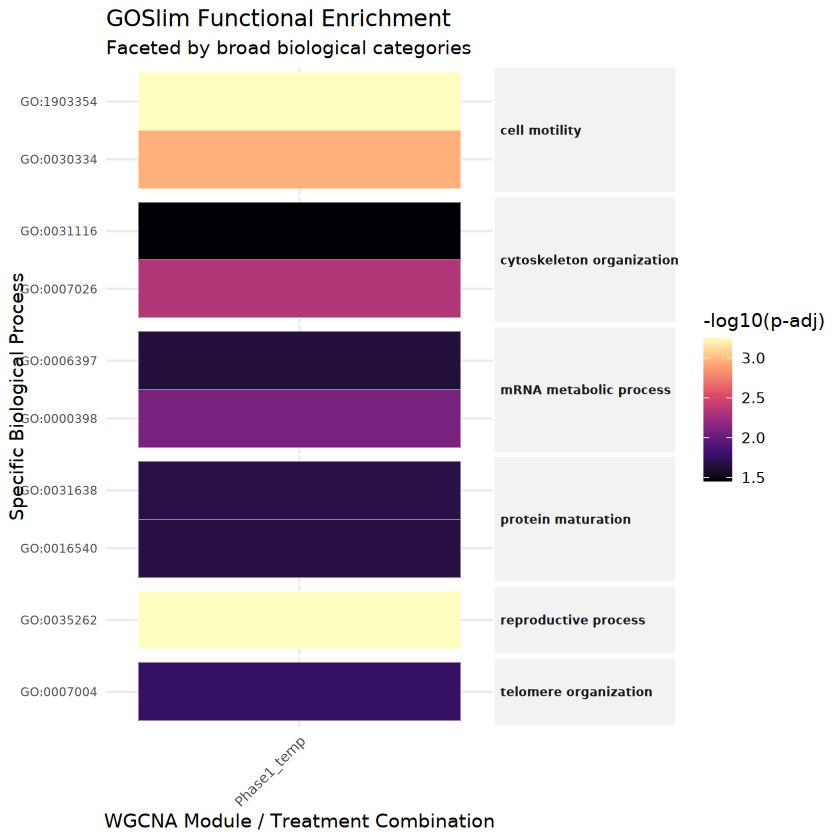

In [89]:
ggplot(midnightblue_res, aes(x = sig_treatment, y = Description, fill = logP)) +
  geom_tile(color = "white", size = 0.1) +
  # Grouping by GOSlim Category on the right side
  facet_grid(GOSlim_Bin ~ ., scales = "free_y", space = "free_y") +
  # Use a color scale that makes significant results "pop"
  scale_fill_viridis_c(option = "magma", name = "-log10(p-adj)") +
  theme_minimal() +
  theme(
    strip.text.y = element_text(angle = 0, size = 7, face = "bold", hjust = 0),
    strip.background = element_rect(fill = "gray95", color = "white"),
    axis.text.y = element_text(size = 7),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
    panel.spacing = unit(0.1, "lines"),
    legend.position = "right"
  ) +
  labs(
    title = "GOSlim Functional Enrichment",
    subtitle = "Faceted by GOSlim Categories",
    x = "Significant Treatment",
    y = "GO Term"
  )